# import module

In [1]:
import os
gpu_number = "0"
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_number
from glob import glob

import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as keras_backend
import segmentation_models as sm

from src.data_loader.segmentation import SegDataloader

sm.set_framework ('tf.keras')

Segmentation Models: using `keras` framework.


In [2]:
gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from src.data_loader.segmentation import SegDataloader
from glob import glob

BACKBONE="inceptionv3"

task = "segmentation"
data_set_name = "glomerulus_0.65_1024_remove_peel_split_man"
batch_size = 8
on_memory = True
argumentation_proba = 0.8
preprocess_input = sm.get_preprocessing(BACKBONE)
target_size = (512,512)
interpolation = "bilinear"
dtype = "float32"


train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/train/image/*")
train_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/train/mask/*")

valid_image_path_list = glob(f"./datasets/{task}/{data_set_name}/valid/image/*")
valid_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/valid/mask/*")

test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/test/image/*")
test_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/test/mask/*")

train_data_loader = SegDataloader(image_path_list=train_image_path_list,
                                  mask_path_list=train_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  argumentation_proba=argumentation_proba,
                                  preprocess_input=preprocess_input,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
valid_data_loader = SegDataloader(image_path_list=valid_image_path_list,
                                  mask_path_list=valid_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  argumentation_proba=0,
                                  preprocess_input=preprocess_input,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
test_data_loader = SegDataloader(image_path_list=test_image_path_list,
                                 mask_path_list=test_mask_path_list,
                                 batch_size=1,
                                 on_memory=False,
                                 argumentation_proba=0,
                                 preprocess_input=preprocess_input,
                                 target_size=target_size,
                                 interpolation=interpolation,
                                 shuffle=False,
                                 dtype=dtype
                                 )

 [4600/4600] |##############################################| (Time:  0:01:47) 
 [05/415] |                                                 | (ETA:   0:00:10) 

Total data num 4600


 [415/415] |################################################| (Time:  0:00:10) 


Total data num 415
Total data num 1111


In [4]:
# create the base pre-trained model~
model = sm.Unet(backbone_name=BACKBONE, input_shape=(
            None, None, 3), classes=1, activation='sigmoid')

In [5]:
from datetime import date

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Nadam

from src.util.custom_loss import PropotionalDiceLoss, TverskyLoss, dice_score, dice_loss, boundary_loss
from segmentation_models.losses import DiceLoss, BinaryFocalLoss

today = date.today()

# YY/MM/dd
today_str = today.strftime("%Y-%m-%d")
today_weight_path = f"./result_daily/{task}/{data_set_name}/{today_str}/{gpu_number}/target_size_{target_size}/weights/" 
today_logs_path = f"./result_daily/{task}/{data_set_name}/{today_str}/{gpu_number}/target_size_{target_size}/"
os.makedirs(today_weight_path, exist_ok=True)
os.makedirs(today_logs_path, exist_ok=True)
optimizer = Nadam(1e-4, clipnorm=1)

save_c = ModelCheckpoint(
    today_weight_path+"/weights_{val_loss:.4f}_{loss:.4f}_{epoch:02d}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-7)
csv_logger = CSVLogger(f'{today_logs_path}/log.csv', append=False, separator=',')


def make_model_trainable(epoch, model, target_epoch):
    if epoch > target_epoch:
        for layer in model.layers:
            layer.trainable = True
            
make_trainable_callback = LambdaCallback(
    on_epoch_begin=lambda epoch,logs: make_model_trainable(epoch, model, target_epoch=epoch_release_frozen)
)

model.compile(optimizer=optimizer, loss=PropotionalDiceLoss(include_focal=True, include_boundary=True), metrics=[dice_score])

In [6]:
start_epoch = 0
epochs = 200

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger, make_trainable_callback],
    initial_epoch=start_epoch
)

Epoch 1/200
575/575 [==============================] - 305s 479ms/step - loss: 0.2154 - dice_score: 0.4570 - val_loss: 0.0889 - val_dice_score: 0.6695
Epoch 2/200
575/575 [==============================] - 270s 469ms/step - loss: 0.0835 - dice_score: 0.7087 - val_loss: 0.0642 - val_dice_score: 0.7987
Epoch 3/200
575/575 [==============================] - 270s 469ms/step - loss: 0.0571 - dice_score: 0.7832 - val_loss: 0.1002 - val_dice_score: 0.8782
Epoch 4/200
575/575 [==============================] - 270s 469ms/step - loss: 0.0539 - dice_score: 0.7690 - val_loss: 0.0453 - val_dice_score: 0.8288
Epoch 5/200
575/575 [==============================] - 274s 476ms/step - loss: 0.0381 - dice_score: 0.8205 - val_loss: 0.0432 - val_dice_score: 0.8926
Epoch 6/200
575/575 [==============================] - 270s 469ms/step - loss: 0.0437 - dice_score: 0.8121 - val_loss: 0.0464 - val_dice_score: 0.8990
Epoch 7/200
575/575 [==============================] - 273s 475ms/step - loss: 0.0344 - dice_s

KeyboardInterrupt: 

In [6]:
model.load_weights("./results/segmentation/glomerulus_0.65_1024_remove_peel_split_man/(512,512)/proportional_dice_focal_boundary_loss/blur/weights_0.0386_0.0131_64.hdf5")
model.evaluate(test_data_loader)

1111/1111 [==============================] - 51s 39ms/step - loss: 0.0346 - dice_score: 0.9452


[0.034591421484947205, 0.9451596736907959]

In [30]:
temp = K.sum(test_image, axis=[1,2,3])
temp = K.expand_dims(temp, axis=-1)

In [6]:
test_image, test_mask = train_data_loader[0]

test_image = tf.constant(test_image)
predicted_mask = model.predict(test_image)

In [7]:
import tensorflow_addons as tfa
from tensorflow_addons.image import euclidean_dist_transform
from tensorflow.keras import backend as K

In [69]:
def calc_dist_map(y_true, epsilon=1e-7):

    reverse_y_true = 1 - y_true

    y_true_uint8 = K.cast(y_true, dtype="uint8")
    reverse_y_true_uint8 = K.cast(reverse_y_true, dtype="uint8")

    dist_map = euclidean_dist_transform(y_true_uint8)
    reverse_dist_map = euclidean_dist_transform(reverse_y_true_uint8)

    total_dist_map = reverse_dist_map * y_true - \
        (dist_map - 1) * reverse_y_true
    
    total_dist_map = K.abs(total_dist_map)
    
#     dist_map_max = K.max(total_dist_map, axis=[1,2,3]) + epsilon
#     dist_map_max = K.expand_dims(dist_map_max, axis=-1)
#     dist_map_max = K.expand_dims(dist_map_max, axis=-1)
#     dist_map_max = K.expand_dims(dist_map_max, axis=-1)
    
#     total_dist_map = total_dist_map / dist_map_max
    
    return total_dist_map


def boundary_loss(y_true, y_pred):
    y_true_dist_map = calc_dist_map(y_true)

    multipled = y_pred * y_true_dist_map

    return K.mean(multipled)


In [71]:
boundary_loss(temp_mask_tensor, temp_mask_predicted)

<tf.Tensor: shape=(), dtype=float32, numpy=0.094529435>

In [52]:
model.load_weights("./results/segmentation/glomerulus_0.65_1024_remove_peel_split_man/(512,512)/proportional_dice_focal_loss/blur/weights_0.0079_0.0038_48.hdf5")

In [6]:
temp_image, temp_mask = train_data_loader[0]
temp_mask_tensor = tf.constant(temp_mask)
temp_mask_predicted = model(temp_image)

ERROR! Session/line number was not unique in database. History logging moved to new session 434


# Unused Code

In [8]:
import csv

with open('./results/segmentation/glomerulus_0.65_1024_remove_peel_split_man/(512,512)/proportional_dice_focal_loss/blur/log.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    dict_from_csv = {field_name:[] for field_name in reader.fieldnames}
    print(reader.fieldnames)
    for row in reader:
        for filedname in reader.fieldnames:
            dict_from_csv[filedname].append(float(row[filedname])) 

['epoch', 'dice_score', 'loss', 'lr', 'val_dice_score', 'val_loss']


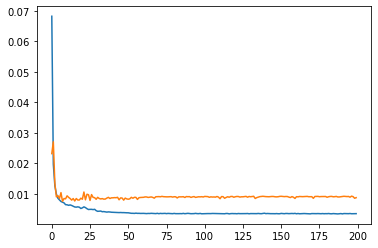

In [20]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["loss"])
plt.plot(dict_from_csv["val_loss"])
plt.show()

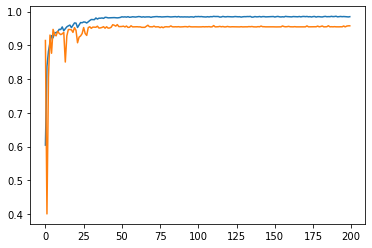

In [16]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["dice_score"])
plt.plot(dict_from_csv["val_dice_score"])
plt.show()